In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from collections import deque
from scipy.optimize import curve_fit


In [2]:
def power_law(x, a, tau):
    """Power-law function for fitting."""
    return a * x**(-tau)
    
def initialize_lattice(size, dim):
    spins = -np.ones((size, size))
    return spins

def initialize_random_fields(R, size):
    h_rand = np.random.normal(0, R, (size, size))
    return h_rand

def calculate_magnetization(spins):
    return np.sum(spins/(np.size(spins)))
    
# Return local field at position (i, j)
def return_local_field(dim, size, spins, J, h, H, i, j):
    neighbours = [[(i+1)%size, j%size], [(i-1)%size, j%size], [i%size, (j+1)%size], [i%size, (j-1)%size]]
    
    h_eff = 0
    
    for neighbour in neighbours:
        h_eff += J*spins[neighbour[0], neighbour[1]]

    h_eff += h[i, j] + H
    # print(h_eff)
    return h_eff

def avalanche(dim, size, spins, J, h, H, fwd_flag):
    h_sorted = []
    for i in range(size):
        for j in range(size):
            heapq.heappush(h_sorted, (-h[i, j], [i, j]))
            
    flipped_spins = []
    queue = deque()

    if fwd_flag == True:
        # Forward process: flip -1 to +1
        while h_sorted:
            _, (i, j) = heapq.heappop(h_sorted)
            if spins[i, j] == -1:    
                h_eff = return_local_field(dim, size, spins, J, h, H, i, j)
                if h_eff > 0:
                    spins[i, j] *= -1
                    flipped_spins.append([i, j])
                    queue.append([i, j])
                
        while queue:
            i, j = queue.popleft()
            neighbours = [[(i+1)%size, j], [(i-1)%size, j], [i, (j+1)%size], [i, (j-1)%size]]
            for neighbour in neighbours:
                if spins[neighbour[0], neighbour[1]] == -1:
                    h_eff = return_local_field(dim, size, spins, J, h, H, neighbour[0], neighbour[1])
                    if h_eff > 0:
                        spins[neighbour[0], neighbour[1]] *= -1
                        flipped_spins.append(neighbour)
                        queue.append(neighbour)
                        
        avalanche_size = len(flipped_spins)
        magnetization = calculate_magnetization(spins)
        return magnetization, avalanche_size

    else:
        # Reverse process: flip +1 to -1
        while h_sorted:
            _, (i, j) = heapq.heappop(h_sorted)
            if spins[i, j] == 1:  # Check for spins in the up state
                h_eff = return_local_field(dim, size, spins, J, h, H, i, j)
                if h_eff < 0:  # Flip if the effective field is negative
                    spins[i, j] *= -1
                    flipped_spins.append([i, j])
                    queue.append([i, j])
                
        while queue:
            i, j = queue.popleft()
            neighbours = [[(i+1)%size, j], [(i-1)%size, j], [i, (j+1)%size], [i, (j-1)%size]]
            for neighbour in neighbours:
                if spins[neighbour[0], neighbour[1]] == 1:  # Check for spins in the up state
                    h_eff = return_local_field(dim, size, spins, J, h, H, neighbour[0], neighbour[1])
                    if h_eff < 0:  # Flip if the effective field is negative
                        spins[neighbour[0], neighbour[1]] *= -1
                        flipped_spins.append(neighbour)
                        queue.append(neighbour)
                        
        avalanche_size = len(flipped_spins)
        magnetization = calculate_magnetization(spins)
        return magnetization, avalanche_size

In [3]:
size = 256
dim = 2

J = 1
R = 2.1

# avalanche
H_start = -10
H_end = 10
H_step = 0.1

In [4]:
spins = initialize_lattice(size, dim)

In [5]:
h = initialize_random_fields(R, size)

In [6]:
magnetizations_fwd = []
avalanche_sizes_fwd = []
Hs = np.arange(H_start, H_end, H_step)

for H_curr in tqdm(Hs, desc="Forward Process"):
    magnetization, avalanche_size = avalanche(dim, size, spins, J, h, H_curr, fwd_flag=True)
    magnetizations_fwd.append(magnetization)
    avalanche_sizes_fwd.append(avalanche_size)

# Reverse process: Decrease H from H_end to H_start
magnetizations_rev = []
avalanche_sizes_rev = []
for H_curr in tqdm(Hs[::-1], desc="Reverse Process"):
    magnetization, avalanche_size = avalanche(dim, size, spins, J, h, H_curr,fwd_flag=False)
    magnetizations_rev.append(-magnetization)
    avalanche_sizes_rev.append(avalanche_size)

Reverse Process: 100%|████████████████████| 200/200 [00:34<00:00,  5.88it/s]


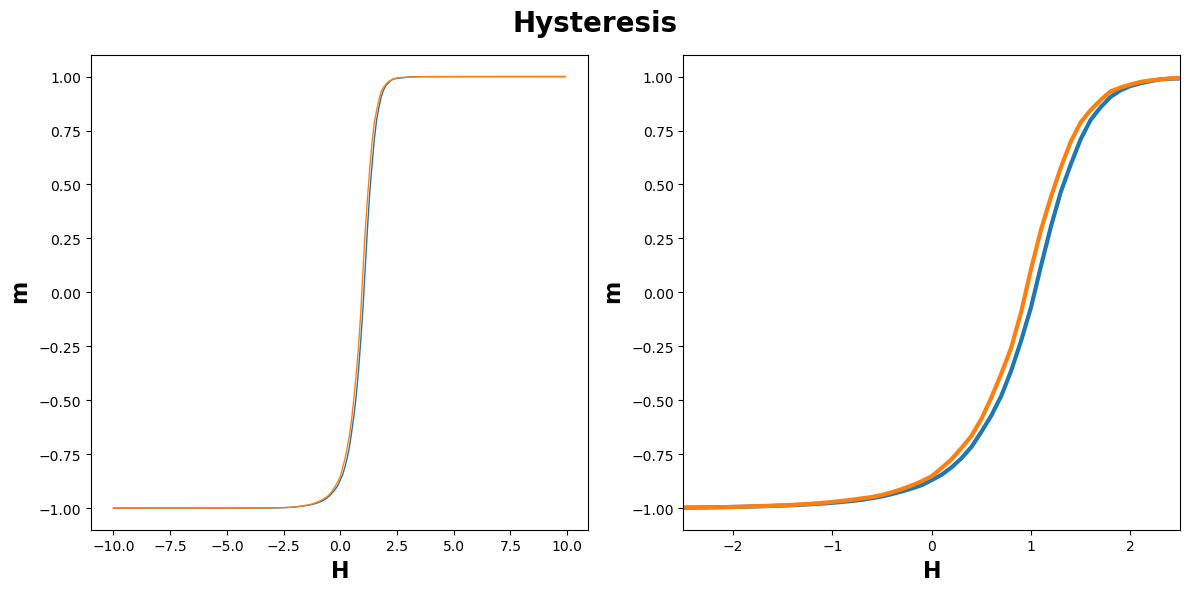

In [7]:
# Bold-ify the axes ticks

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(Hs, magnetizations_fwd, linewidth = 1, label = "fwd")
ax[0].plot(Hs, magnetizations_rev, linewidth = 1, label = "rev")
ax[0].set_xlabel(r"$\mathbf{H}$", fontsize = 16)
ax[0].set_ylabel(r"$\mathbf{m}$", fontsize = 16)

ax[1].plot(Hs, magnetizations_fwd, linewidth = 3, label = "fwd")
ax[1].plot(Hs, magnetizations_rev, linewidth = 3, label = "rev")
ax[1].set_xlim([-2.5, 2.5])
ax[1].set_xlabel(r"$\mathbf{H}$", fontsize = 16)
ax[1].set_ylabel(r"$\mathbf{m}$", fontsize = 16)

fig.suptitle("Hysteresis", fontsize = 20, fontweight = "bold")
fig.tight_layout()

/tmp/ipykernel_108649/1817864690.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_small, _ = curve_fit(power_law, bin_centers[mask_small], hist[mask_small], p0=[0, 3])


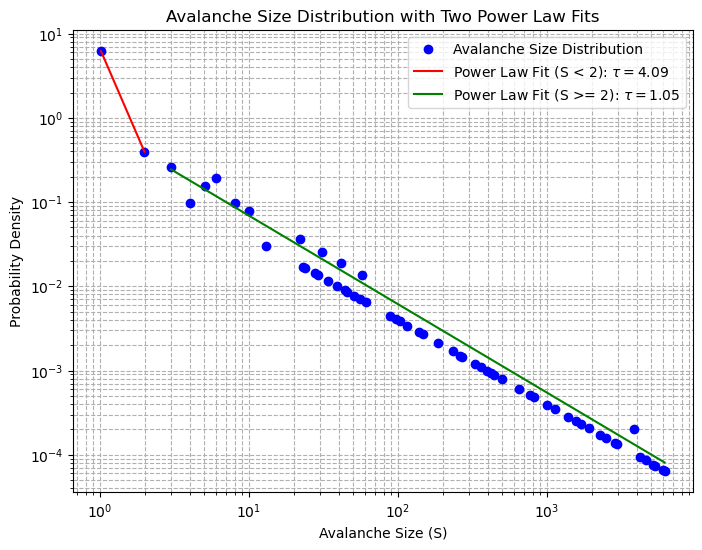

In [10]:
hist, bin_edges = np.histogram(avalanche_sizes_fwd, bins=np.logspace(0, np.log10(max(avalanche_sizes_fwd)), 300), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter out zero values in the histogram (log(0) is undefined)
valid_indices = hist > 0
bin_centers = bin_centers[valid_indices]
hist = hist[valid_indices]

# Identify the crossover point (e.g., S_c = 10)
S_c = 2
mask_small = bin_centers < S_c  # Data for S < S_c
mask_large = bin_centers >= S_c  # Data for S >= S_c

# Fit the first power law (for S < S_c)
popt_small, _ = curve_fit(power_law, bin_centers[mask_small], hist[mask_small], p0=[0, 3])

# Fit the second power law (for S >= S_c)
popt_large, _ = curve_fit(power_law, bin_centers[mask_large], hist[mask_large], p0=[0, 3])

# Plot the distribution and the power-law fits
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, hist, 'bo', label='Avalanche Size Distribution')
plt.loglog(bin_centers[mask_small], power_law(bin_centers[mask_small], *popt_small), 'r-', label=f'Power Law Fit (S < {S_c}): $\\tau = {popt_small[1]:.2f}$')
plt.loglog(bin_centers[mask_large], power_law(bin_centers[mask_large], *popt_large), 'g-', label=f'Power Law Fit (S >= {S_c}): $\\tau = {popt_large[1]:.2f}$')
plt.xlabel('Avalanche Size (S)')
plt.ylabel('Probability Density')
plt.title('Avalanche Size Distribution with Two Power Law Fits')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()